# СБЕР. Тестовое задание.

In [1]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

In [2]:
%load_ext tensorboard 

# Загружаем данные

In [3]:
DATA_PATH = "/content/sample_data"

In [ ]:
!! wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz -O $DATA_PATH/imagewoof2.tgz

In [ ]:
!! tar -xvzf $DATA_PATH/imagewoof2.tgz -C $DATA_PATH/

Обрабатываем данные.

In [6]:
ROOT = DATA_PATH + '/imagewoof2/'
LABELS_PRESICION = 'noisy_labels_0'

data = pd.read_csv(ROOT + 'noisy_imagewoof.csv').loc[:, ['path', LABELS_PRESICION]]
data.head()

,path,noisy_labels_0
0,train/n02115641/n02115641_3995.JPEG,n02115641
1,train/n02115641/n02115641_843.JPEG,n02115641
2,train/n02115641/n02115641_2953.JPEG,n02115641
3,train/n02115641/n02115641_6458.JPEG,n02115641
4,train/n02115641/n02115641_19414.JPEG,n02115641


In [7]:
labelsDict = {v: i for i, v in enumerate(data.noisy_labels_0.unique())}

In [8]:
data.columns = ['path', 'label']
data.label = data.label.apply(lambda x: labelsDict[x])
data.path = data.path.apply(lambda x: ROOT + x)
data.head()

,path,label
0,/content/sample_data/imagewoof2/train/n0211564...,0
1,/content/sample_data/imagewoof2/train/n0211564...,0
2,/content/sample_data/imagewoof2/train/n0211564...,0
3,/content/sample_data/imagewoof2/train/n0211564...,0
4,/content/sample_data/imagewoof2/train/n0211564...,0


Разбиваем данные на тренировочную и валидационную выборки

In [9]:
trainDF = data.iloc[0:9025]
valDF = data.iloc[9025:].set_index(pd.Index(range(len(data.iloc[9025:]))))

# Dataset

Некоторые вспомогательные методы

In [10]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [11]:
# для SummaryWriter
RESULTS_ROOT = Path("/content/results/")
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "imagewoof"

# cuda, если доступна
DEVICE = torch.device(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Имплементируем датасет

In [12]:
class ImagewoofDataset(Dataset):
  _transform: Optional[Transform]
  _root: Path
  _df: DataFrame

  def __init__(self, df, transform: Optional[Transform] = None):
    self._transform = transform
    self._df = df

  def __getitem__(self, index: int) -> DatasetItem:
    path, label = self._df.loc[index, :]
    image = Image.open(path).convert("RGB")
    if self._transform:
        image = self._transform(image)
    return DatasetItem(image=image, label=label, id=index, path=path)

  def __len__(self) -> int:
    return len(self._df)

# Loader'ы


In [ ]:
import PIL
transform = transforms.Compose(
  [   
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ]
)

train_dataset = ImagewoofDataset(trainDF, transform=transform )
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

val_dataset = ImagewoofDataset(valDF, transform=transform )
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

#Training

In [14]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer, scheduler):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )


    scheduler.step()

    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, val_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(val_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            val_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print(
        "\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            val_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    writer.add_scalar("val_loss_plot", val_loss, global_step=epoch)
    writer.add_scalar(
        "val_accuracy_plot",
        100.0 * correct / len(val_loader.dataset),
        global_step=epoch,
    )

In [15]:
from torch.optim import lr_scheduler
import torch.nn as nn

# Возьмем предобученный ResNet и применим finetuning чтобы дообучить его на нашей задаче
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

loss_function = loss.CrossEntropyLoss()

optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.001)

# Будем обучать крайние слои сети с разными lr
optimizer_conv.add_param_group({'params': model.layer4.parameters(),'lr': 0.0001})
optimizer_conv.add_param_group({'params': model.layer3.parameters(),'lr': 0.0001})
optimizer_conv.add_param_group({'params': model.layer2.parameters(),'lr': 0.00001})

# Каждые две эпохи уменьшаем lr в 0.1 раза
scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [16]:
for epoch in range(5):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)

    train(model, DEVICE, train_loader, optimizer_conv, loss_function, epoch, writer,scheduler)
    test(model, DEVICE, val_loader, loss_function, epoch, writer)
    writer.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Train Epoch: 0 [ (76%)]	Loss: 0.563259




Val set: Average loss: 0.0016, Accuracy: 3414/3929 (87%)




Train Epoch: 1 [ (90%)]	Loss: 0.253359




Val set: Average loss: 0.0014, Accuracy: 3490/3929 (89%)




Train Epoch: 2 [ (93%)]	Loss: 0.292522




Val set: Average loss: 0.0013, Accuracy: 3519/3929 (90%)




Train Epoch: 3 [ (93%)]	Loss: 0.221058




Val set: Average loss: 0.0012, Accuracy: 3541/3929 (90%)




Train Epoch: 4 [ (94%)]	Loss: 0.212872




Val set: Average loss: 0.0012, Accuracy: 3543/3929 (90%)



# Визуализация результатов

Confusion matrix для нашей модели

In [17]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [18]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10, 10], int)

with torch.no_grad():
    for item in tqdm(val_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


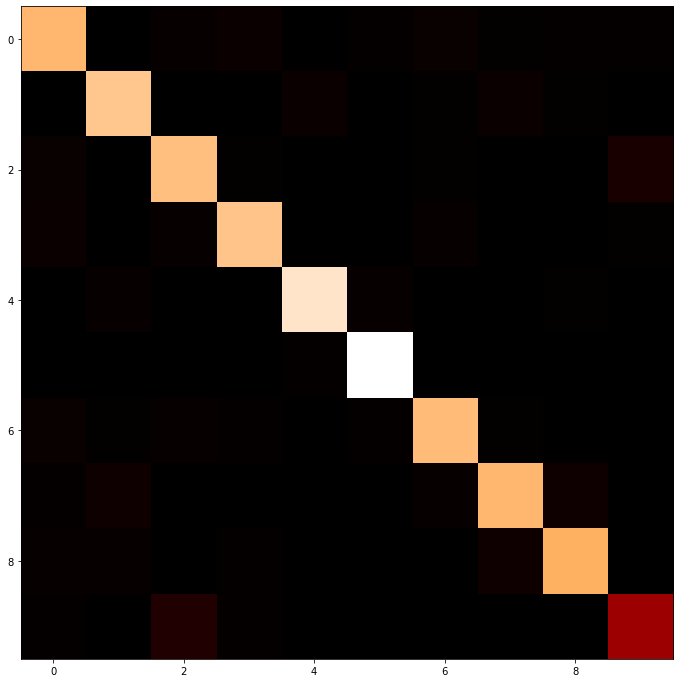

In [19]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

Выводим результаты SummaryWriter

In [ ]:
%tensorboard --logdir {RESULTS_ROOT}